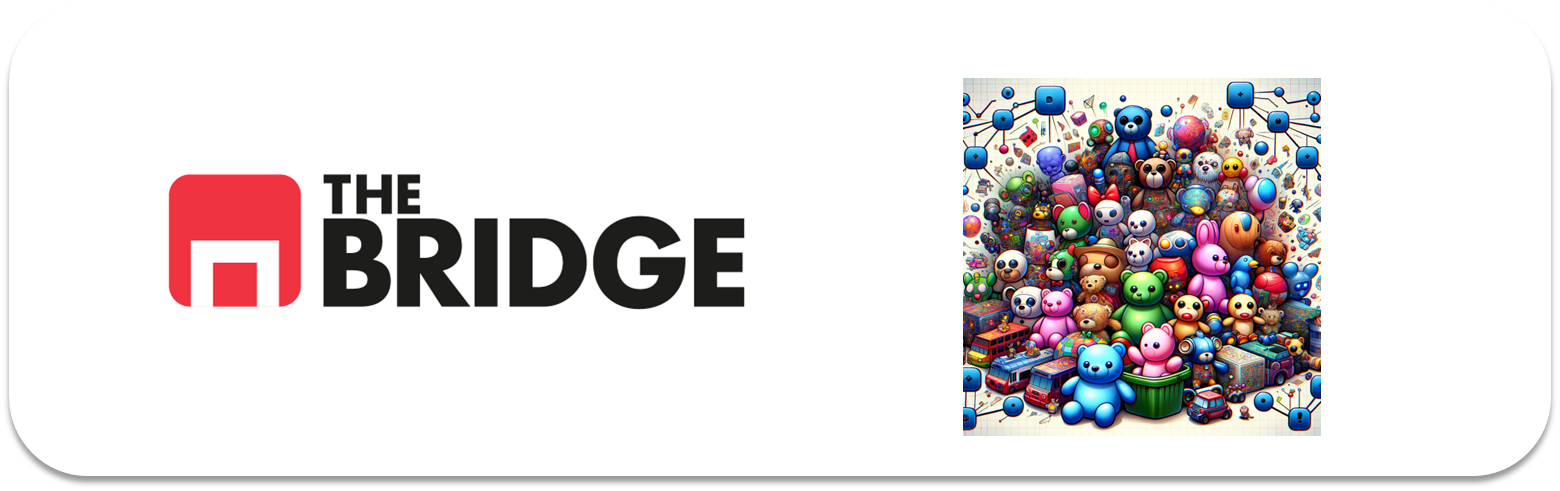

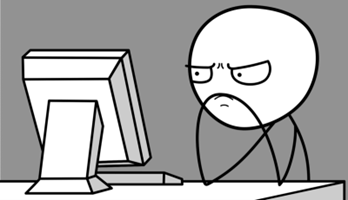

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


### PROBLEMA DE NEGOCIO: hay que segmentar la muestras de bebida energetica utilizando tecnicas de clustering

In [2]:

# Cargar el dataset
df = pd.read_csv("./data/empowering_drinks.csv", sep="|")
df.columns=df.columns.str.replace(' ','_')

# Mostrar las primeras filas para verificar la carga correcta
df.head()

,Azúcares,Vitamínas_del_grupo_B,Cafeína,Ácido_Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


#### ANALISIS DE DATOS+ EDA

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
print(df.dtypes)

Azúcares                 float64
Vitamínas_del_grupo_B    float64
Cafeína                  float64
Ácido_Cítrico            float64
Taurina                  float64
dtype: object


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas_del_grupo_B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido_Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [6]:
# Convertir todas las columnas a tipo numérico
df = df.apply(pd.to_numeric, errors='coerce')

# Verificar que la conversión fue correcta
df.dtypes

Azúcares                 float64
Vitamínas_del_grupo_B    float64
Cafeína                  float64
Ácido_Cítrico            float64
Taurina                  float64
dtype: object

In [7]:
df.describe()

,Azúcares,Vitamínas_del_grupo_B,Cafeína,Ácido_Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


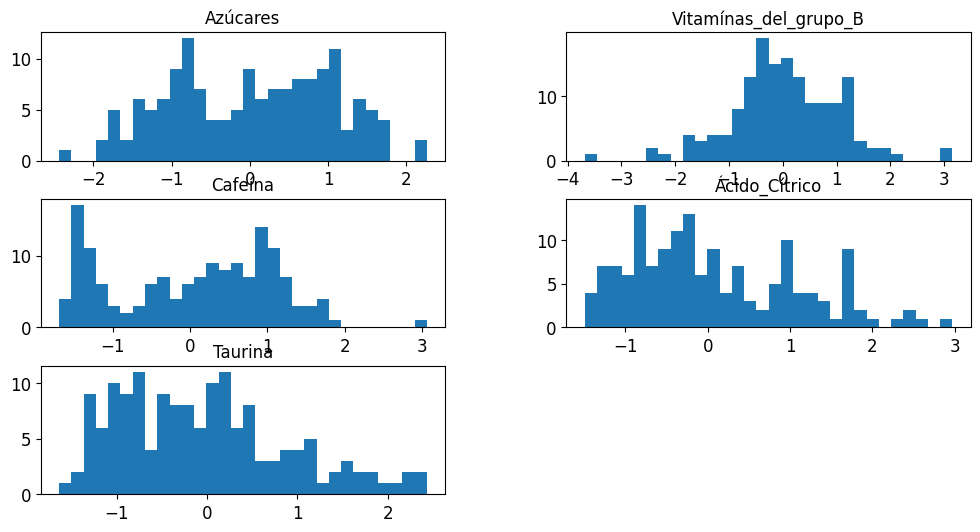

In [8]:
df.hist(bins=30, figsize=(12, 6), grid=False)
plt.show()

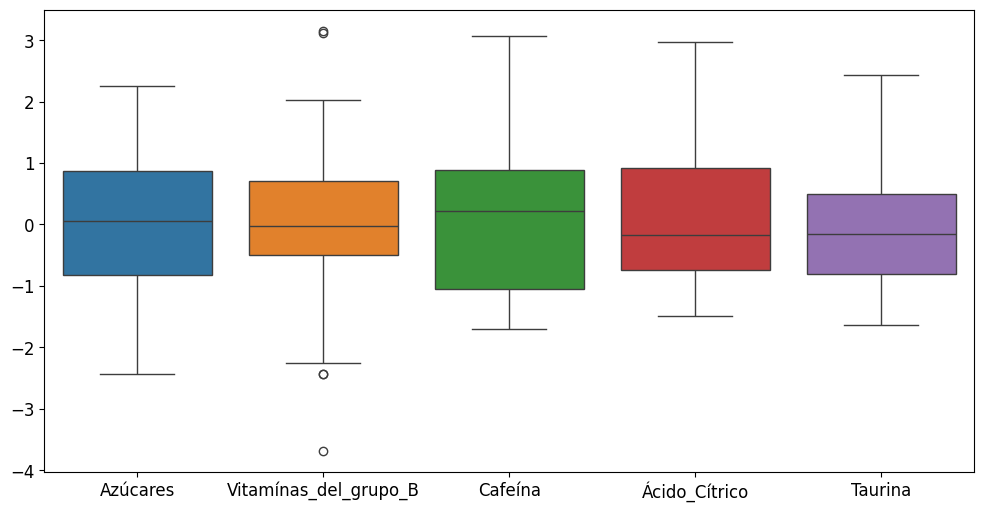

In [9]:
import seaborn as sns

# Crear boxplots para ver valores atípicos
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.show()

#### TRANSFORMACION DE DATOS ESTANDARIZACION, OUTLIERS, LOGARITMOS

In [10]:
from sklearn.preprocessing import StandardScaler

# Escalar todas las variables numéricas
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Ver los primeros valores escalados
df_scaled.head()

,Azúcares,Vitamínas_del_grupo_B,Cafeína,Ácido_Cítrico,Taurina
0,1.465925,0.196207,0.957824,0.927289,0.317612
1,0.221992,-0.871612,0.667526,0.879813,-0.267608
2,0.173684,1.079919,1.132002,1.307094,0.336190
3,1.635003,0.453956,1.373917,2.240782,1.320844
4,0.270301,1.816346,0.599790,-0.117176,-0.295475


In [11]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas_del_grupo_B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido_Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


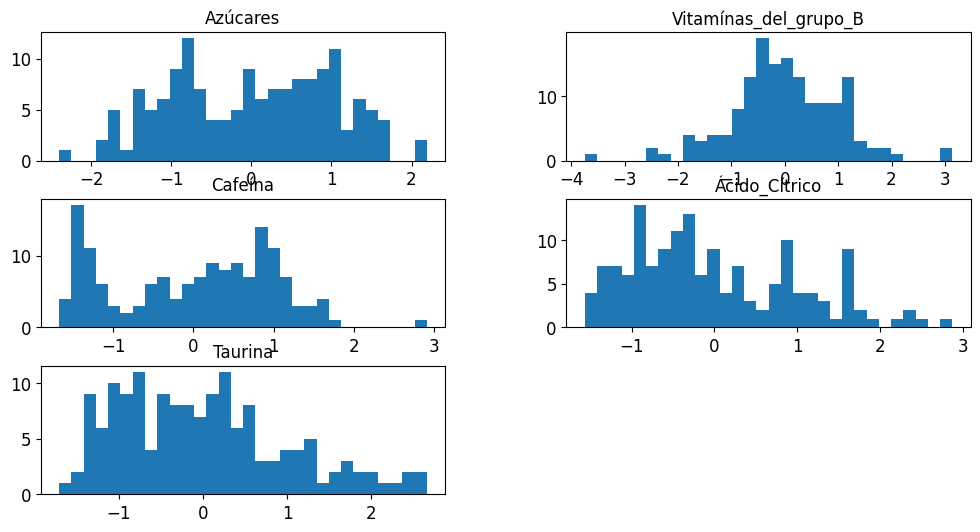

In [12]:
df_scaled.hist(bins=30, figsize=(12, 6), grid=False)
plt.show()

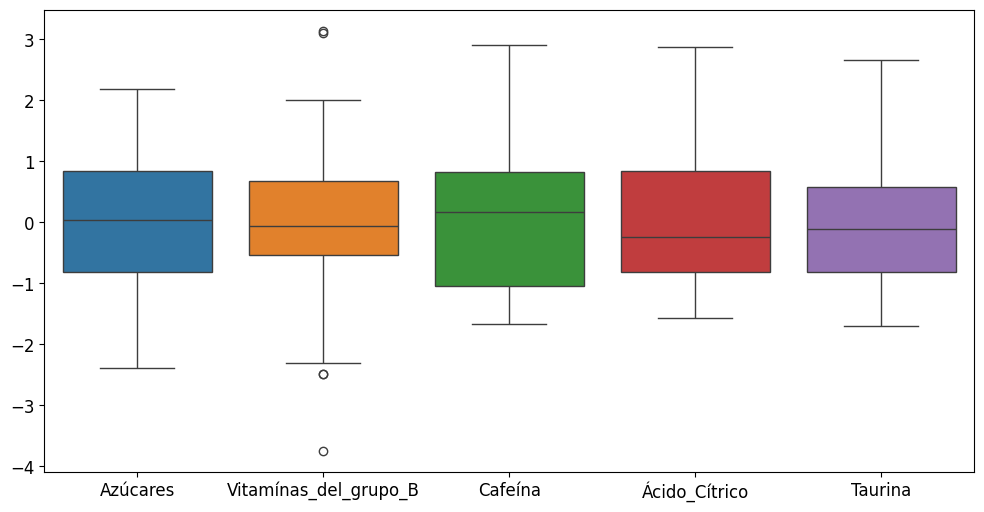

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled)
plt.show()

In [14]:
# Calcular el IQR (rango intercuartílico) para la columna 'Vitaminas_B'
Q1 = df['Vitamínas_del_grupo_B'].quantile(0.25)
Q3 = df['Vitamínas_del_grupo_B'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Eliminar los outliers en 'Vitaminas_B'
df = df[(df['Vitamínas_del_grupo_B'] >= lower_bound) & (df['Vitamínas_del_grupo_B'] <= upper_bound)]

In [15]:
# Aplicar logaritmo (log) a la columna 'Cafeína' para normalizar su distribución
df['Cafeína'] = np.log1p(df['Cafeína'])  # log1p es para manejar valores 0 sin problema Sí

C:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
# Escalar todas las variables numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# Ver los primeros valores escalados
df_scaled.head()

,Azúcares,Vitamínas_del_grupo_B,Cafeína,Ácido_Cítrico,Taurina
0,1.442553,0.211035,0.694504,0.901678,0.301232
1,0.198291,-1.044739,0.446215,0.854609,-0.280542
2,0.149970,1.250296,0.826385,1.278228,0.319701
3,1.611675,0.514153,0.992723,2.203913,1.298558
4,0.246612,2.116347,0.382074,-0.133835,-0.308245


In [17]:
# Eliminar cualquier fila con NaN o valores infinitos
df_scaled = df_scaled.dropna()
df_scaled = df_scaled[np.isfinite(df_scaled).all(axis=1)]

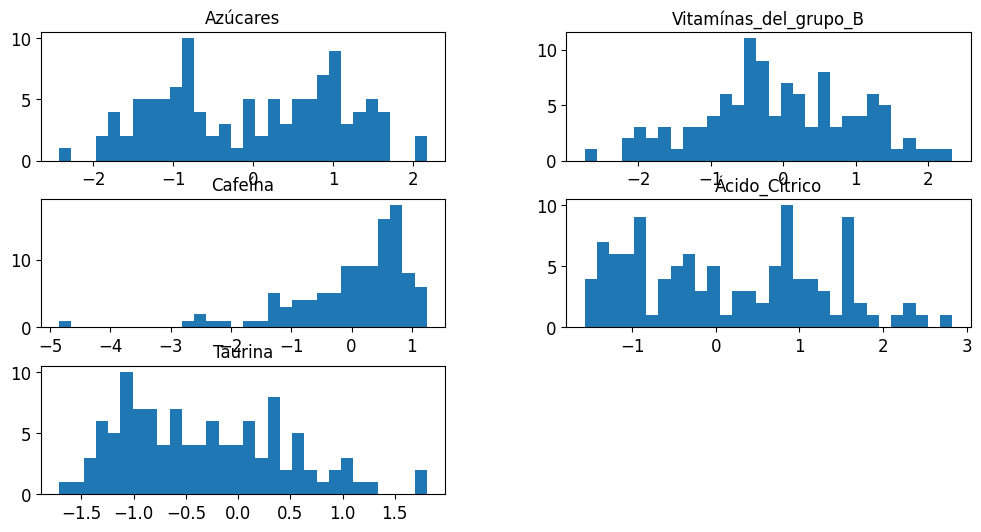

In [18]:
df_scaled.hist(bins=30, figsize=(12, 6), grid=False)
plt.show()

#### VISUALIZACION DOS A DOS

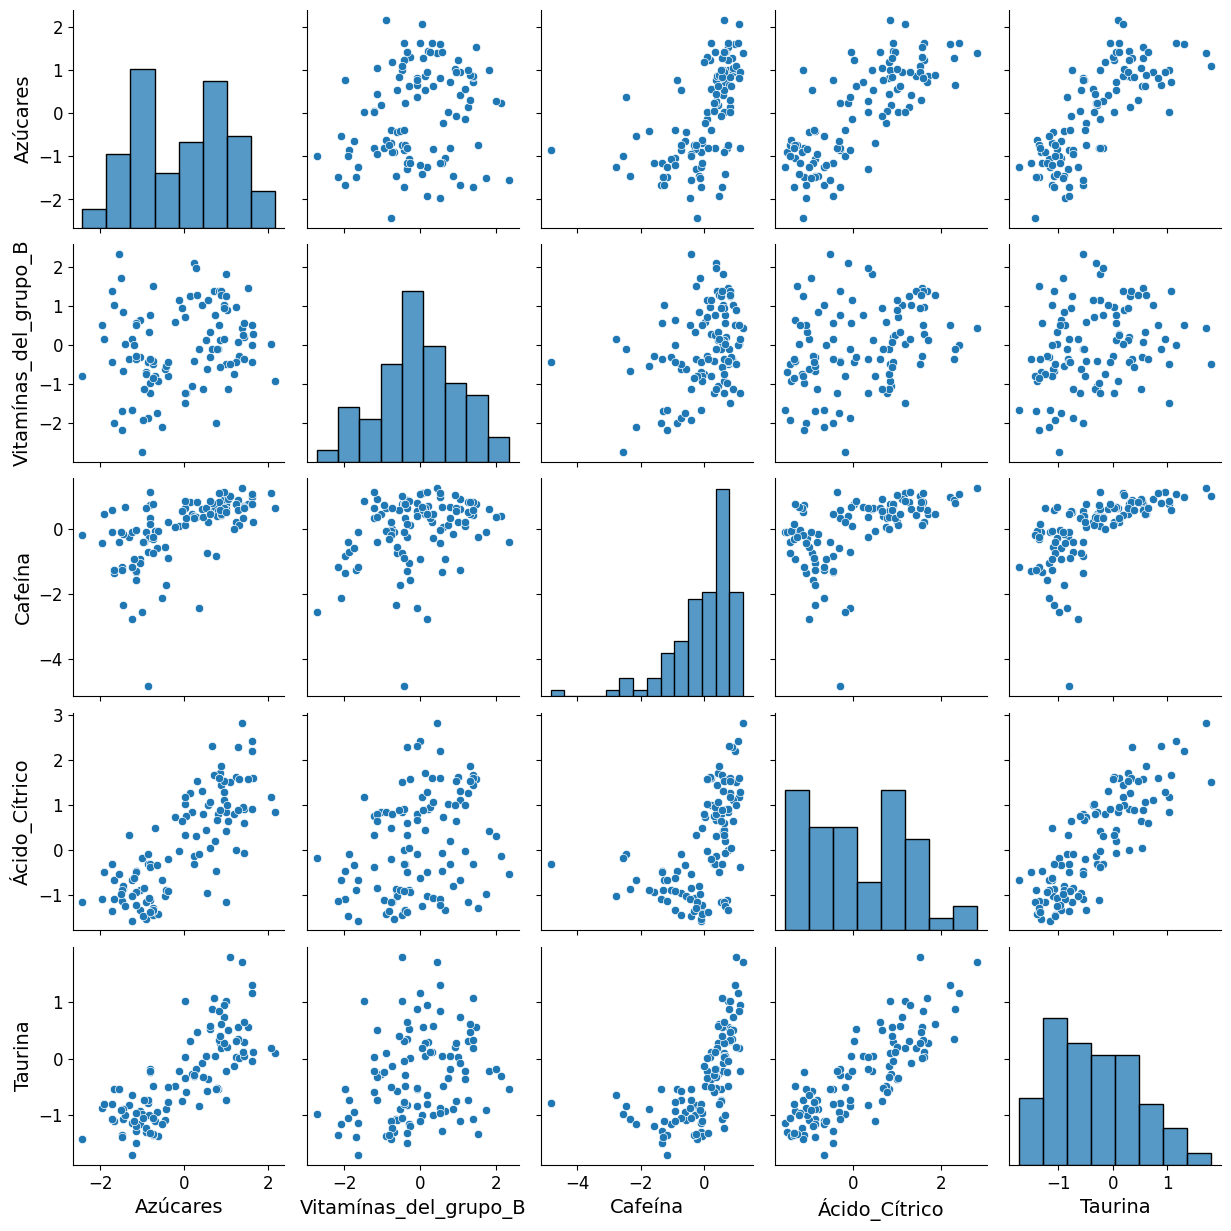

In [19]:

# Visualización de relaciones entre variables (pairplot)
sns.pairplot(df_scaled)  # df_scaled es el dataframe que ya hemos escalado
plt.show()

In [20]:
df_scaled.columns

Index(['Azúcares', 'Vitamínas_del_grupo_B', 'Cafeína', 'Ácido_Cítrico',
       'Taurina'],
      dtype='object')

#### DENDROGRAMA

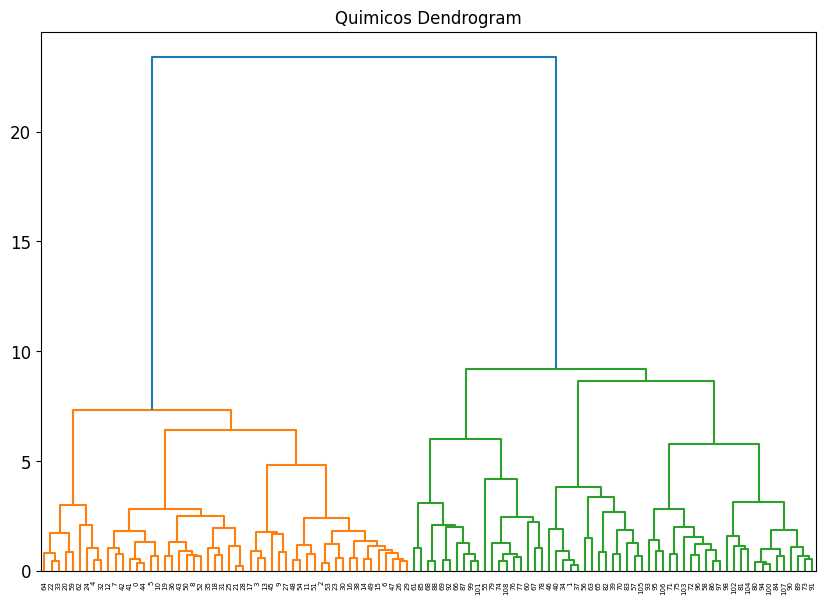

In [21]:

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Quimicos Dendrogram")

selected_data = df_scaled[['Azúcares', 'Vitamínas_del_grupo_B', 'Cafeína', 'Ácido_Cítrico',
       'Taurina']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

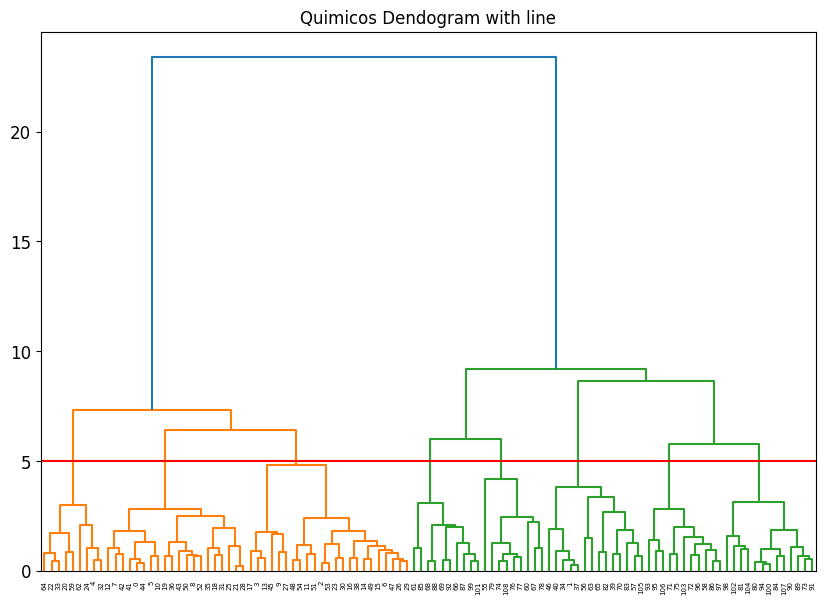

In [22]:
plt.figure(figsize=(10, 7))
plt.title("Quimicos Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 5, color = 'r', linestyle = '-')

#### APLICACION DE N CLUSTER SEGUN DENDROGRAMA

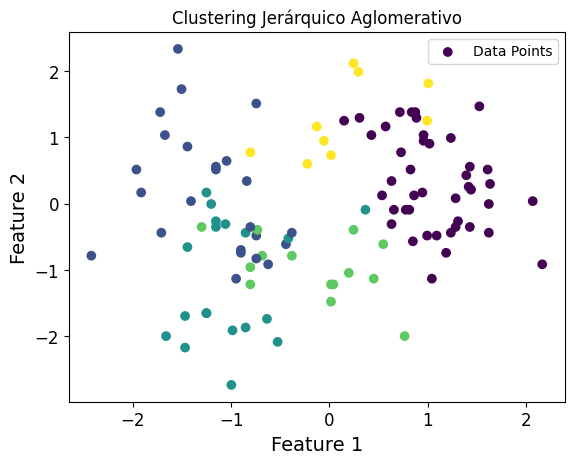

In [23]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


df_scaled_array= df_scaled.to_numpy()


# El número de clústeres se elige visualmente del dendrograma, por ejemplo, 5
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')

#  Ajustamos el modelo a los datos escalados
clustering.fit(df_scaled_array)

# Obtener las etiquetas (asignación de clúster)
labels = clustering.labels_

# Visualizar los resultados del clúster jerárquico en 2D (como en K-means o PCA)
plt.scatter(df_scaled_array[:, 0], df_scaled_array[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.title('Clustering Jerárquico Aglomerativo')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#### DBSCAN

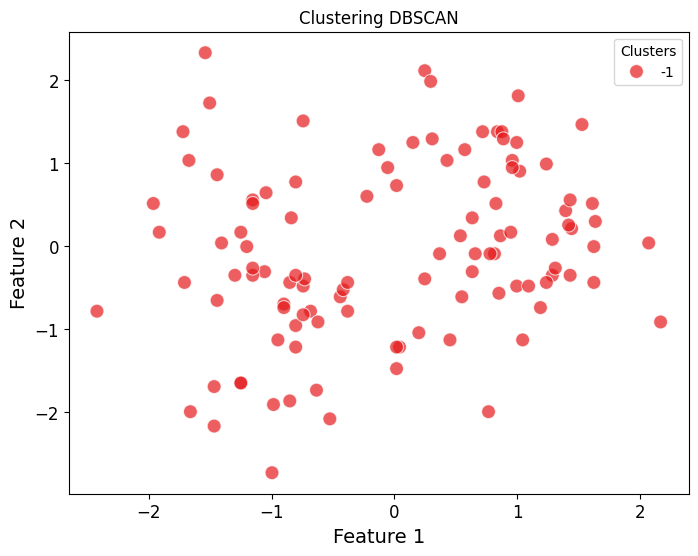

Número de clústeres encontrados por DBSCAN: 0


In [24]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los parámetros de DBSCAN
eps = 0.04  # Distancia máxima entre dos puntos para que pertenezcan al mismo clúster
min_samples = 2  # Número mínimo de puntos para formar un clúster

# Aplicar DBSCAN al conjunto de datos escalados
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_scaled['cluster_dbscan'] = dbscan.fit_predict(df_scaled)

# Visualizar los resultados de DBSCAN en un gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled.iloc[:, 0], y=df_scaled.iloc[:, 1], hue=df_scaled['cluster_dbscan'], palette='Set1', s=100, alpha=0.7)
plt.title('Clustering DBSCAN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Clusters', loc='best')
plt.show()

# Ver cuántos clústeres se han formado (recuerda que -1 es ruido)
print(f'Número de clústeres encontrados por DBSCAN: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}')

Sin resultados concretos con este modelo intentamos cambiar la distancia basandonos en la distancia k-esima

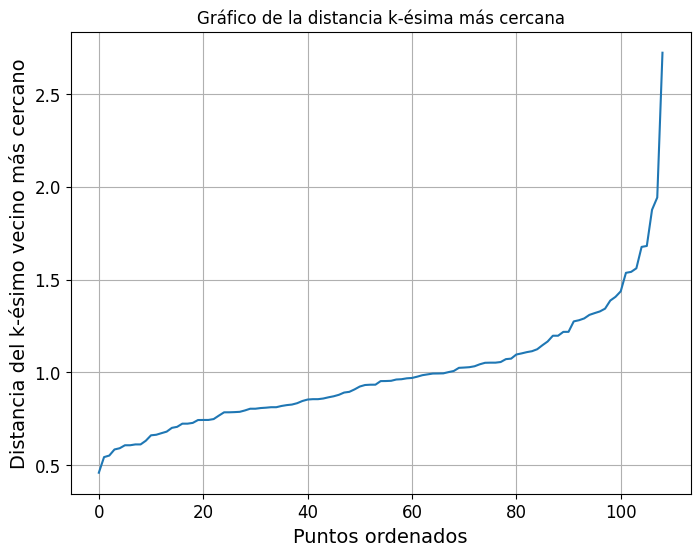

In [25]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Calcular la distancia k-ésima más cercana para cada punto
k = 4  # Elegimos k=4 por ejemplo (puedes probar otros valores)
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(df_scaled)
distances, indices = neigh.kneighbors(df_scaled)

# Ordenar las distancias de menor a mayor
distances = np.sort(distances[:, k-1], axis=0)

# Graficar las distancias para elegir el valor de 'eps'
plt.figure(figsize=(8,6))
plt.plot(distances)
plt.title('Gráfico de la distancia k-ésima más cercana')
plt.xlabel('Puntos ordenados')
plt.ylabel('Distancia del k-ésimo vecino más cercano')
plt.grid(True)
plt.show()

#### K-MEANS

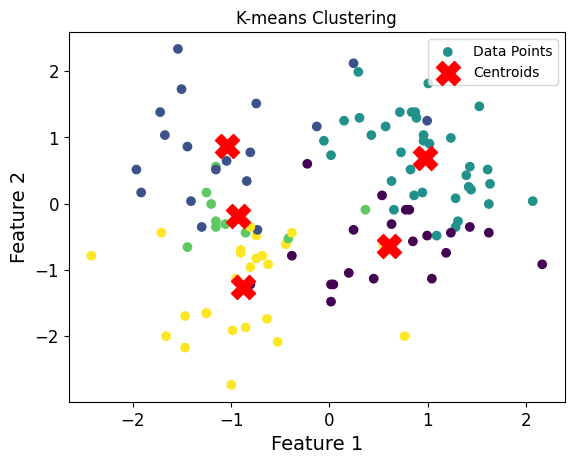

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes el DataFrame escalado
# Si df_scaled es un DataFrame de Pandas, convierte a un array de NumPy
df_scaled_array = df_scaled.to_numpy()

# Número de clústeres que se debe determinar con el método del codo u otra técnica
k = 5  # Número de clústeres que has elegido

# Crear el modelo de K-means
kmeans = KMeans(n_clusters=k, random_state=42)

# Ajustar el modelo a los datos escalados
kmeans.fit(df_scaled_array)

# Obtener los resultados
labels = kmeans.labels_  # Etiquetas de clústeres asignadas a cada punto
centroids = kmeans.cluster_centers_  # Coordenadas de los centroides de los clústeres

# Visualizar los resultados en 2D (si tienes más de 2 características, puedes seleccionar 2)
# Aquí estamos usando las primeras dos columnas para la visualización
plt.scatter(df_scaled_array[:, 0], df_scaled_array[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

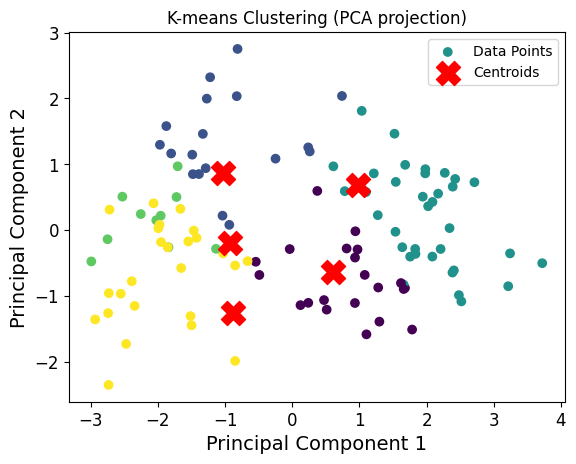

In [27]:
from sklearn.decomposition import PCA

# Aplicamos PCA para reducir los datos a 2 dimensiones para visualización
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled_array)

# Ahora visualizamos los resultados de K-means en el espacio 2D de PCA
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-means Clustering (PCA projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [28]:
k_range=range(1, 8)

In [29]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=25).fit(df_pca) for k in k_range]

# Obtener la inercia (suma de las distancias cuadradas de cada punto a su centroide)
inertias = [model.inertia_ for model in kmeans_per_k]

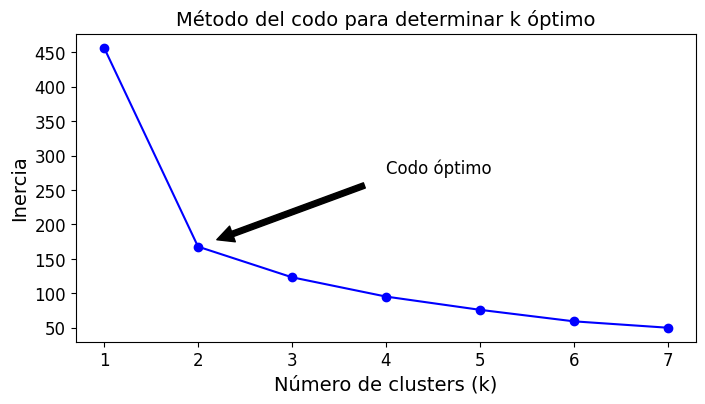

El número óptimo de clusters según el método del codo parece ser k = 2


In [30]:
# Grafico con cambio en la anotacion, la inercia en función de k
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("Número de clusters (k)", fontsize=14)
plt.ylabel("Inercia", fontsize=14)
plt.title("Método del codo para determinar k óptimo", fontsize=14)

# Anotación para marcar el punto del codo (ajustar manualmente si es necesario)
optimal_k = 0  # Inicializamos en 0 y lo detectaremos visualmente
for i in range(1, len(inertias) - 1):
    if abs(inertias[i - 1] - inertias[i]) > abs(inertias[i] - inertias[i + 1]):
        optimal_k = k_range[i]
        break

plt.annotate('Codo óptimo', 
             xy=(optimal_k, inertias[optimal_k - 1]), 
             xytext=(optimal_k + 2, inertias[0] * 0.6),
             textcoords='data',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()

print(f"El número óptimo de clusters según el método del codo parece ser k = {optimal_k}")

#### CONCLUSIONES 

Con base en todo lo que has probado y los resultados obtenidos, parece que 5 clústeres es la opción más robusta y coherente para segmentar los datos, pero hemos demconsiderar que un número menor de clústeres, como 2, puede ser útil si buscamos una segmentación más simplificada. La elección final dependera de la granularidad que se deseen en las categorías y del tipo de segmentación que los químicos y el negocio consideren más relevantes

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

#### DATOS MAS EDA

In [31]:
# Cargar los nuevos datos
data = pd.read_csv('./data/new_experiments.csv', sep='|')

# Mostrar las primeras filas para inspeccionar los datos
data.head(10)

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [32]:
data.columns=data.columns.str.replace(' ','_')
data.columns

Index(['Azúcares', 'Vitamínas_del_grupo_B', 'Cafeína', 'Ácido_Cítrico',
       'Taurina'],
      dtype='object')

In [33]:
data. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               6 non-null      float64
 1   Vitamínas_del_grupo_B  6 non-null      float64
 2   Cafeína                6 non-null      float64
 3   Ácido_Cítrico          6 non-null      float64
 4   Taurina                6 non-null      float64
dtypes: float64(5)
memory usage: 372.0 bytes


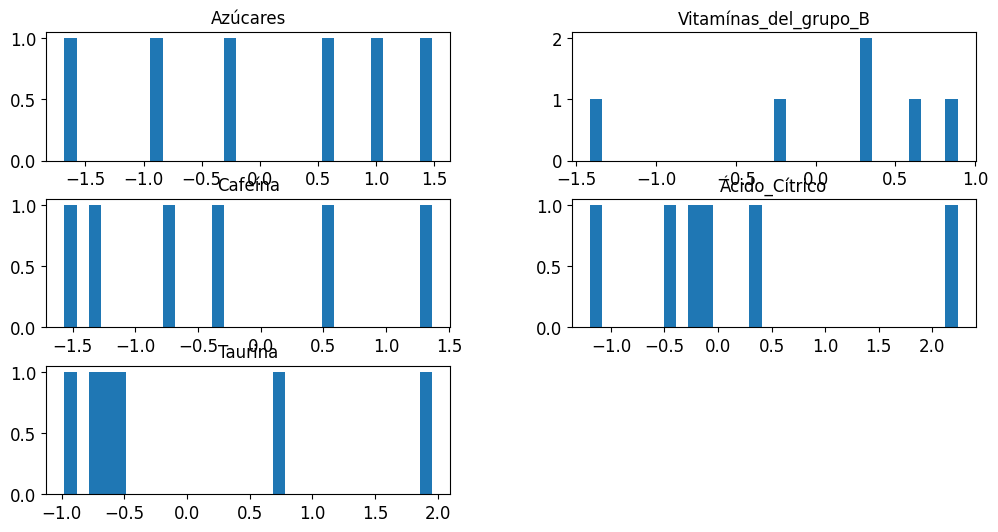

In [34]:
data.hist(bins=30, figsize=(12, 6), grid=False)
plt.show()

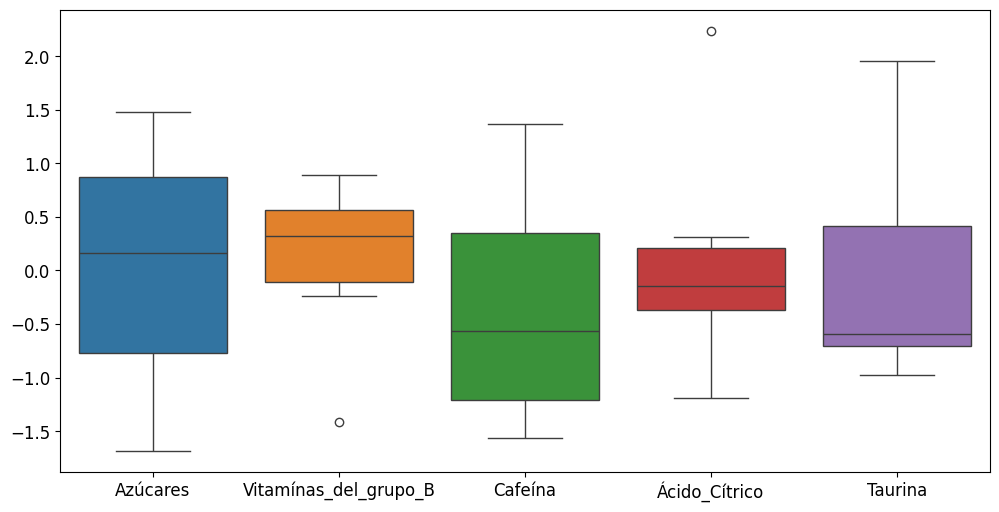

In [35]:
# Crear boxplots para ver valores atípicos
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.show()

Aplicamos logaritmo a cafeina y escalamos las variables al tener tan pocos datos no quitamos lo aoutliers

In [36]:
# Aplicar logaritmo (log) a la columna 'Cafeína' para normalizar su distribución
data['Cafeína'] = np.log1p(data['Cafeína'])  # log1p es para manejar valores 0 sin problema Sí

C:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
from sklearn.preprocessing import StandardScaler

# Escalar todas las variables numéricas
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Ver los primeros valores escalados
data_scaled

,Azúcares,Vitamínas_del_grupo_B,Cafeína,Ácido_Cítrico,Taurina
0,1.442553,0.211035,0.694504,0.901678,0.301232
1,0.198291,-1.044739,0.446215,0.854609,-0.280542
2,0.149970,1.250296,0.826385,1.278228,0.319701
3,1.611675,0.514153,0.992723,2.203913,1.298558
4,0.246612,2.116347,0.382074,-0.133835,-0.308245
...,...,...,...,...,...
143,0.439895,0.427548,NaN,-0.086766,1.067696
144,0.282853,-0.525108,NaN,0.179957,2.406699
145,0.162051,-0.048780,NaN,0.195646,1.991146
146,1.321751,1.553414,NaN,-0.682971,1.944974


In [40]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               148 non-null    float64
 1   Vitamínas_del_grupo_B  148 non-null    float64
 2   Cafeína                109 non-null    float64
 3   Ácido_Cítrico          148 non-null    float64
 4   Taurina                148 non-null    float64
dtypes: float64(5)
memory usage: 5.9 KB


In [42]:
# Eliminar cualquier fila con NaN o valores infinitos
data_scaled = data_scaled.dropna()
data_scaled = data_scaled[np.isfinite(df_scaled).all(axis=1)]

In [45]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 0 to 110
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               109 non-null    float64
 1   Vitamínas_del_grupo_B  109 non-null    float64
 2   Cafeína                109 non-null    float64
 3   Ácido_Cítrico          109 non-null    float64
 4   Taurina                109 non-null    float64
dtypes: float64(5)
memory usage: 5.1 KB


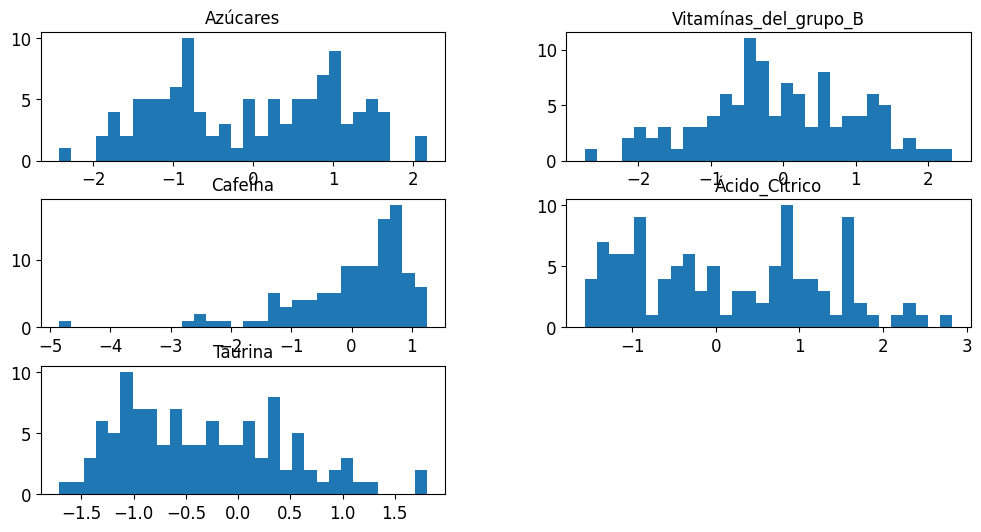

In [43]:
data_scaled.hist(bins=30, figsize=(12, 6), grid=False)
plt.show()

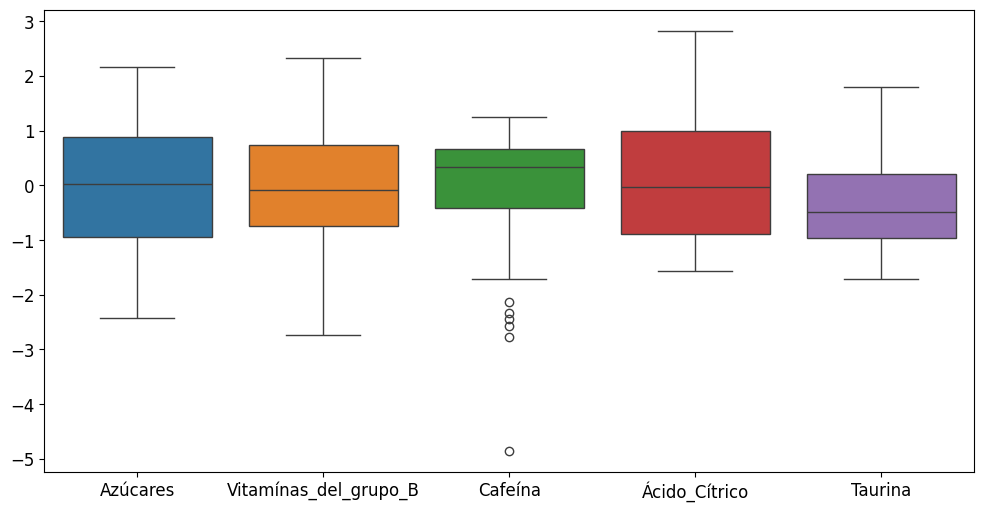

In [44]:
# Crear boxplots para ver valores atípicos
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_scaled)
plt.show()

#### APLICACION DE K-MEANS Y DENDROGRAMA

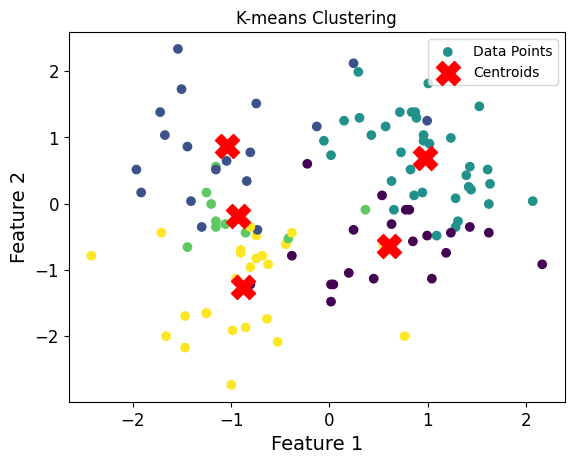

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


# Si data_scaled es un DataFrame de Pandas, convierte a un array de NumPy
data_scaled_array = df_scaled.to_numpy()

# Número de clústeres que se debe determinar con el método del codo u otra técnica
k = 5  # Número de clústeres que has elegido

# Crear el modelo de K-means
kmeans = KMeans(n_clusters=k, random_state=42)

# Ajustar el modelo a los datos escalados
kmeans.fit(data_scaled_array)

# Obtener los resultados
labels = kmeans.labels_  # Etiquetas de clústeres asignadas a cada punto
centroids = kmeans.cluster_centers_  # Coordenadas de los centroides de los clústeres

# Visualizar los resultados en 2D (si tienes más de 2 características, puedes seleccionar 2)
# Aquí estamos usando las primeras dos columnas para la visualización
plt.scatter(data_scaled_array[:, 0], data_scaled_array[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

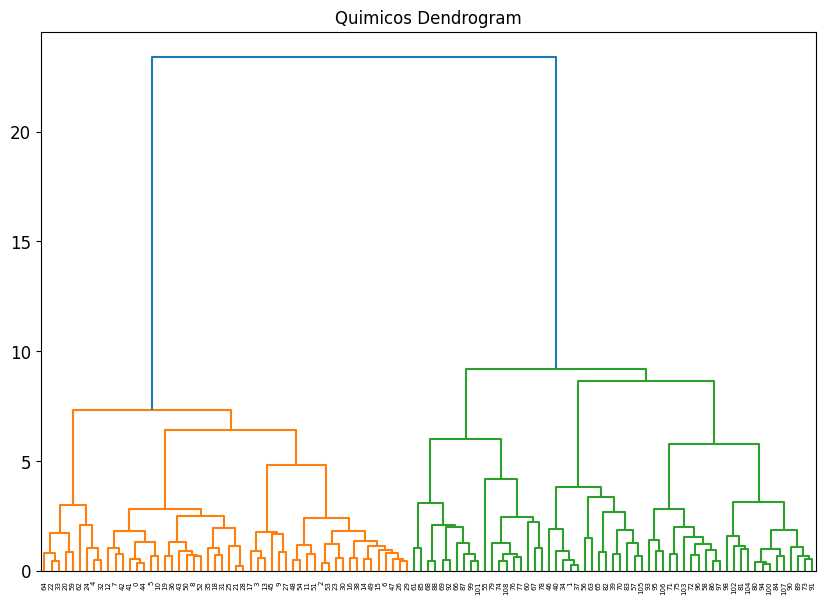

In [47]:

import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Quimicos Dendrogram")

selected_data = data_scaled[['Azúcares', 'Vitamínas_del_grupo_B', 'Cafeína', 'Ácido_Cítrico',
       'Taurina']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

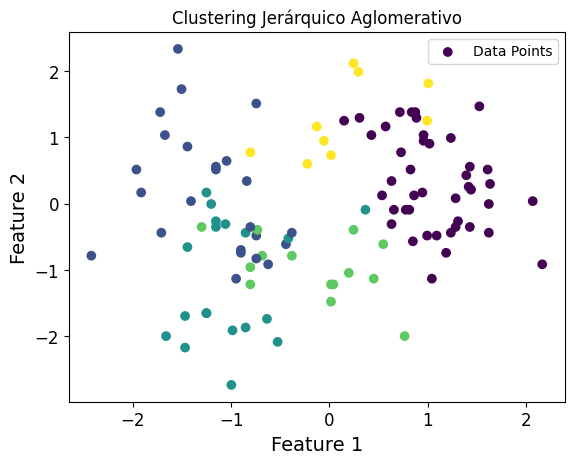

In [49]:

data_scaled_array= data_scaled.to_numpy()


# El número de clústeres se elige visualmente del dendrograma, por ejemplo, 5
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward')

#  Ajustamos el modelo a los datos escalados
clustering.fit(data_scaled_array)

# Obtener las etiquetas (asignación de clúster)
labels = clustering.labels_

# Visualizar los resultados del clúster jerárquico en 2D (como en K-means o PCA)
plt.scatter(data_scaled_array[:, 0], data_scaled_array[:, 1], c=labels, cmap='viridis', label='Data Points')
plt.title('Clustering Jerárquico Aglomerativo')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#### CONCLUSIONES

Resultado similar al anterior, cinco clusters

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.